In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

In [38]:
base_dir = "../data/final"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255
)

In [40]:
"""
rotation_range=20 - Randomly rotate images by up to 20 degrees.
width_shift_range=0.2 - Randomly shift images horizontally up to 20% of the image width.
height_shift_range=0.2 - Randomly shift images vertically up to 20% of the image height.
shear_range=0.2 - Randomly shear transforms.
zoom_range=0.2 - Randomly enlarge or reduce images.
horizontal_flip=True - Randomly flip images horizontally.
fill_mode='nearest' - How to fill in missing pixels after augmentation (uses nearest neighbor).
"""


"\nrotation_range=20 - Randomly rotate images by up to 20 degrees.\nwidth_shift_range=0.2 - Randomly shift images horizontally up to 20% of the image width.\nheight_shift_range=0.2 - Randomly shift images vertically up to 20% of the image height.\nshear_range=0.2 - Randomly shear transforms.\nzoom_range=0.2 - Randomly enlarge or reduce images.\nhorizontal_flip=True - Randomly flip images horizontally.\nfill_mode='nearest' - How to fill in missing pixels after augmentation (uses nearest neighbor).\n"

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

Found 20412 images belonging to 3 classes.


In [42]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 5103 images belonging to 3 classes.


In [43]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout
predictions = Dense(3, activation='softmax')(x)  # Output layer with 3 neurons (3 classes)

In [44]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {val_generator.samples}")


Number of training samples: 20412
Number of validation samples: 5103


In [46]:
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, val_generator.samples // val_generator.batch_size)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 2551
Validation steps: 637


In [47]:
callbacks = [
    ModelCheckpoint(
        'best_model_grayscale_with_augmentation.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 2020s 788ms/step - accuracy: 0.4715 - loss: 1.1304 - val_accuracy: 0.5787 - val_loss: 0.8844
Epoch 2/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 364s 142ms/step - accuracy: 0.6250 - loss: 0.7412 - val_accuracy: 0.5814 - val_loss: 0.8832
Epoch 3/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 2025s 794ms/step - accuracy: 0.5435 - loss: 0.9446 - val_accuracy: 0.5952 - val_loss: 0.8673
Epoch 4/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 381s 149ms/step - accuracy: 0.5000 - loss: 0.9079 - val_accuracy: 0.5960 - val_loss: 0.8685
Epoch 5/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 2132s 836ms/step - accuracy: 0.5594 - loss: 0.9240 - val_accuracy: 0.6115 - val_loss: 0.8510
Epoch 6/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 364s 142ms/step - accuracy: 0.6250 - loss: 0.8128 - val_accuracy: 0.6083 - val_loss: 0.8523
Epoch 7/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 2157s 846ms/step - accuracy: 0.5753 - loss: 0.9077 - val_accuracy: 0.6230 - val_loss: 0.8361
Epoch 8/20
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 362s 142ms/step 

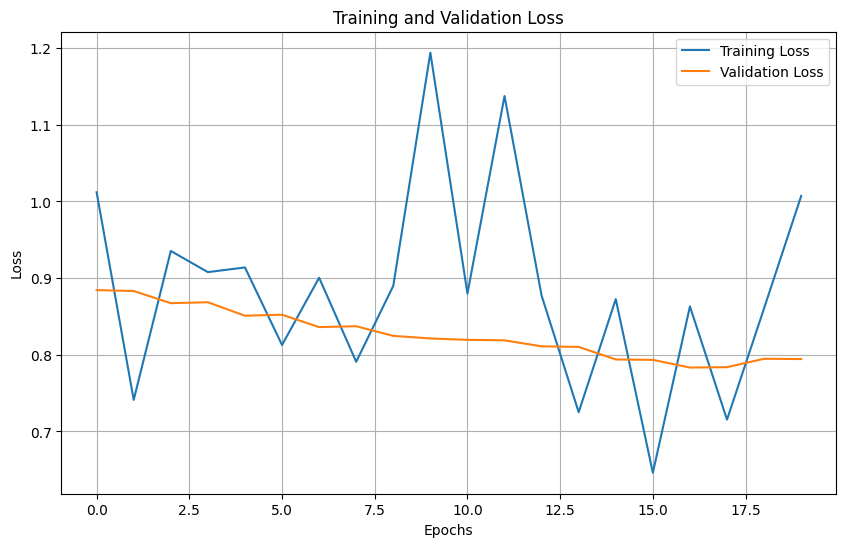

In [48]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


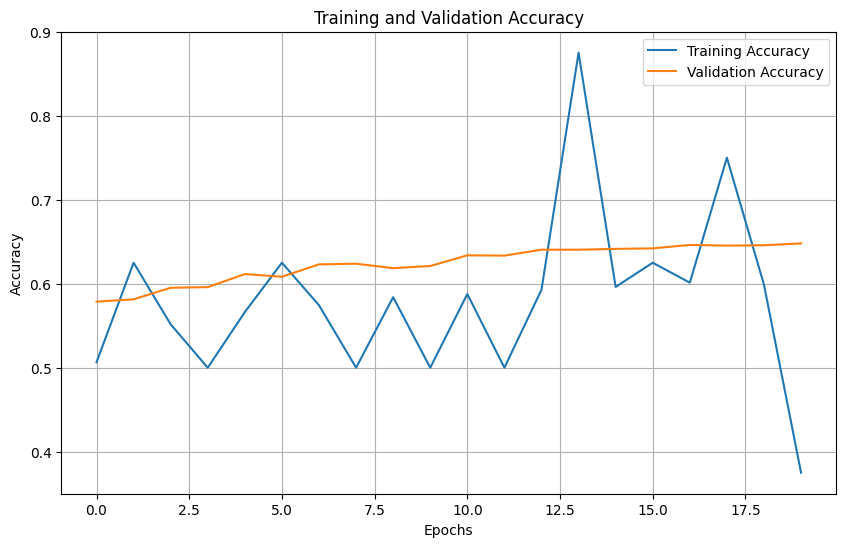

In [49]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
base_model_v2 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

for layer in base_model_v2.layers[:-50]:
    layer.trainable = False

x = base_model_v2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model_v2 = Model(inputs=base_model_v2.input, outputs=predictions)

model_v2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
]

history = model_v2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Epoch 1/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 2527s 984ms/step - accuracy: 0.5773 - loss: 0.8855 - val_accuracy: 0.7403 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 2/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 2944s 1s/step - accuracy: 0.7172 - loss: 0.6612 - val_accuracy: 0.7429 - val_loss: 0.5967 - learning_rate: 1.0000e-04
Epoch 3/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 2844s 1s/step - accuracy: 0.7364 - loss: 0.6024 - val_accuracy: 0.7599 - val_loss: 0.5521 - learning_rate: 1.0000e-04
Epoch 4/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 2463s 965ms/step - accuracy: 0.7536 - loss: 0.5750 - val_accuracy: 0.7658 - val_loss: 0.5374 - learning_rate: 1.0000e-04
Epoch 5/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 2446s 958ms/step - accuracy: 0.7655 - loss: 0.5490 - val_accuracy: 0.7744 - val_loss: 0.5322 - learning_rate: 1.0000e-04
Epoch 6/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 2469s 968ms/step - accuracy: 0.7771 - loss: 0.5186 - val_accuracy: 0.7725 - val_loss: 0.5471 - learning_rate: 1.0000e-04
Epoch 7/10
2552/2552 ━━━━━━━

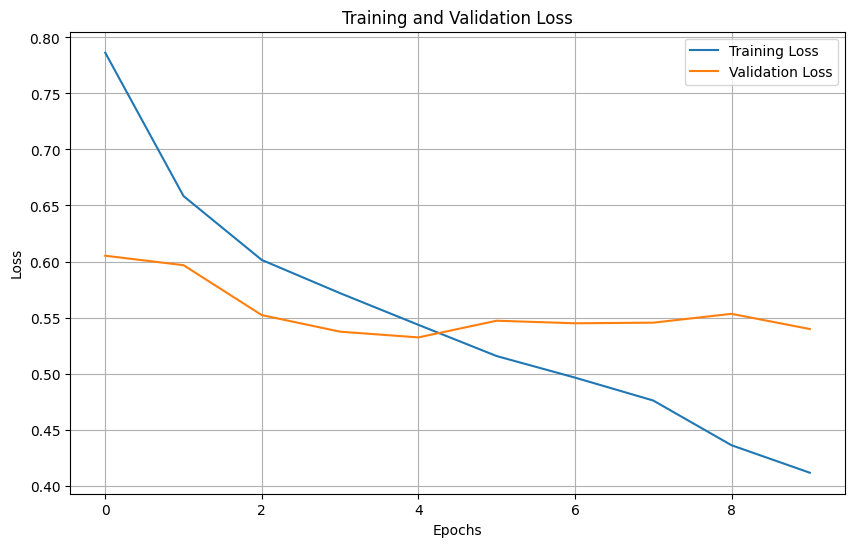

In [52]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

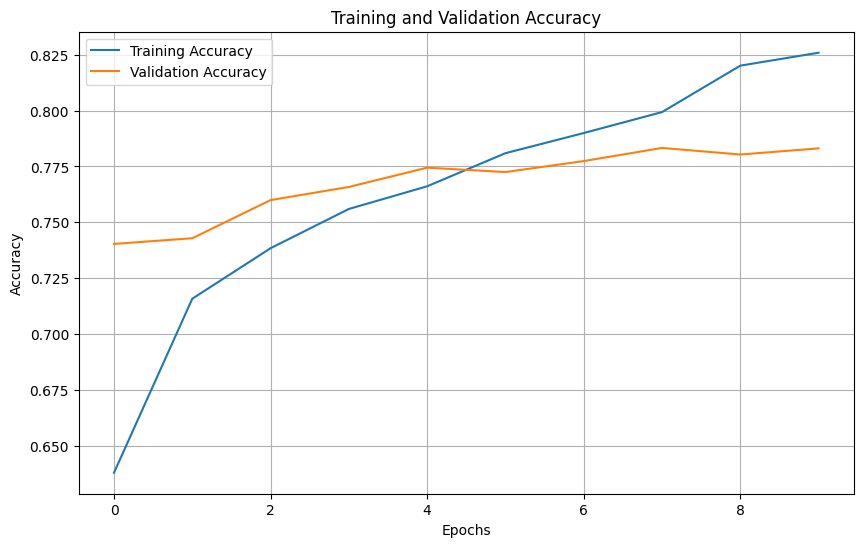

In [53]:

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
base_model_v3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

for layer in base_model_v2.layers[:-30]: # Last 30 layers are trainable
    layer.trainable = False

x = base_model_v3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model_v3 = Model(inputs=base_model_v3.input, outputs=predictions)

model_v3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

# Trenowanie
history = model_v3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Epoch 1/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 6435s 3s/step - accuracy: 0.5327 - loss: 10.5848 - precision: 0.6247 - recall: 0.3472 - val_accuracy: 0.7601 - val_loss: 1.0066 - val_precision: 0.7815 - val_recall: 0.7284 - learning_rate: 1.0000e-04
Epoch 2/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 6417s 3s/step - accuracy: 0.7463 - loss: 0.8979 - precision: 0.7762 - recall: 0.6935 - val_accuracy: 0.7803 - val_loss: 0.5887 - val_precision: 0.8140 - val_recall: 0.7384 - learning_rate: 1.0000e-04
Epoch 3/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 6355s 2s/step - accuracy: 0.7640 - loss: 0.6332 - precision: 0.7838 - recall: 0.7284 - val_accuracy: 0.7913 - val_loss: 0.5365 - val_precision: 0.8060 - val_recall: 0.7662 - learning_rate: 1.0000e-04
Epoch 4/10
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 6470s 3s/step - accuracy: 0.7836 - loss: 0.5696 - precision: 0.8063 - recall: 0.7523 - val_accuracy: 0.7891 - val_loss: 0.5286 - val_precision: 0.8069 - val_recall: 0.7688 - learning_rate: 1.0000e-04
Epoch 5/10
2552/2552 ━━━━━━━━━━

In [59]:
model_v3.save('trained_model_v3.h5')

In [60]:
model_v3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 73, 73,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 73,213,035 (279.29 MB)

 Trainable params: 24,392,867 (93.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 48,785,736 (186.10 MB)

In [61]:
model_v3.evaluate(val_generator)

638/638 ━━━━━━━━━━━━━━━━━━━━ 331s 518ms/step - accuracy: 0.8865 - loss: 0.3241 - precision: 0.9041 - recall: 0.8719


[0.47256454825401306,
 0.8118753433227539,
 0.8269938826560974,
 0.7924749851226807]

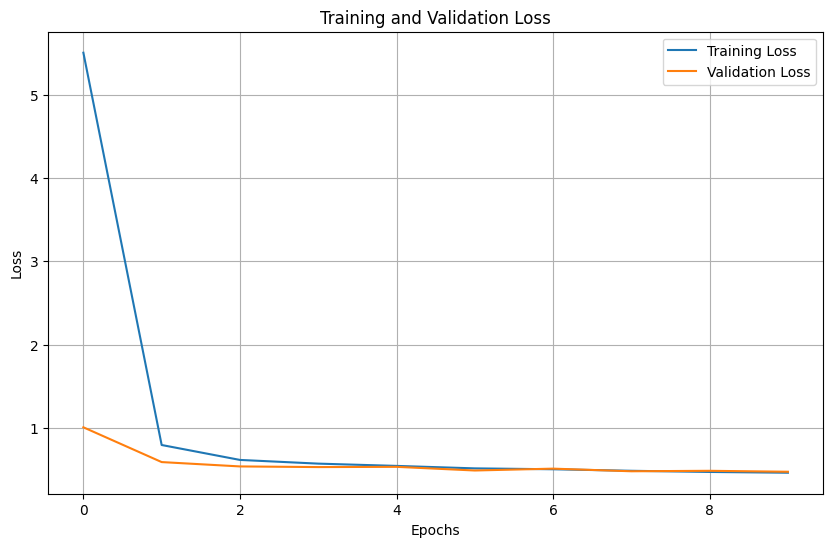

In [62]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

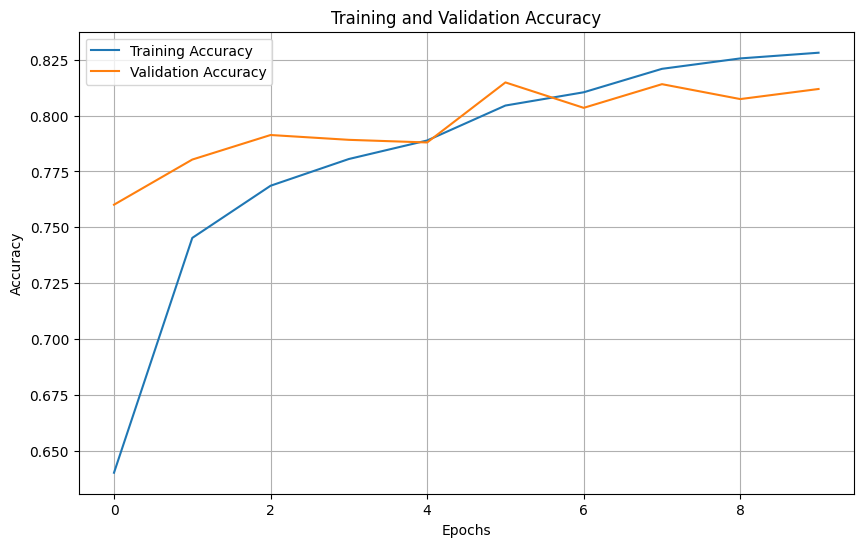

In [63]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Print 4 main metrics

print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
print(f"Loss: {history.history['loss'][-1]}")

Accuracy: 0.8280913233757019
Precision: 0.8414856791496277
Recall: 0.8124632835388184
Loss: 0.46086233854293823
